## Clase Multiagentes 2 | 15 Mayo 2024
- Intro a multiagentes y vecinos
- plot de vecinos
- plot de riqueza
- Coeficiente de gini

In [193]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [194]:
class MoneyAgent(Agent):
    def __init__(self, id,model):
        super().__init__(id, model)
        self.wealth = 1

    def move(self):
        possible_cells = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position = self.random.choice(possible_cells)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents(self.pos)
        if len(cellmates) > 0:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()
        

In [195]:
def compute_gini(model):
    agent_wealth = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealth)
    N = len(model.schedule.agents)
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return (1 + (1 / N) - (2 * B))

In [196]:
class MoneyModel(Model):
    def __init__(self, num_agents, width, height):
        super().__init__()
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)
        self.datacollector = DataCollector(
            agent_reporters = {"Wealth" : "wealth"},
            model_reporters={"Gini" : compute_gini}
        )

        for i in range(num_agents):
            agent = MoneyAgent(i, self)
            self.schedule.add(agent)
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            self.grid.place_agent(agent, (x,y))


    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [197]:
ITERATIONS = 10
SIMULATIONS = 1000
WIDTH = 10
HEIGHT = 10
AGENTS = 10

all_wealth = []
for i in range(SIMULATIONS):
    model = MoneyModel(AGENTS, WIDTH, HEIGHT)
    for j in range(ITERATIONS):
        model.step()

for agent in model.schedule.agents:
    all_wealth.append(agent.wealth)

[Text(0.5, 1.0, 'Wealth distribution'),
 Text(0.5, 0, 'Wealth'),
 Text(0, 0.5, 'Number of agents')]

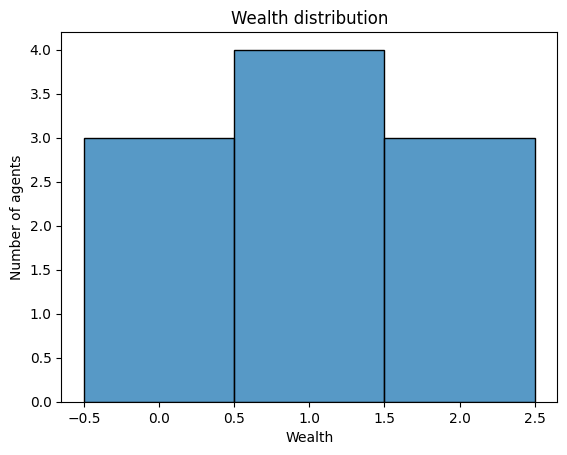

In [198]:
fig = plt.plot(figsize=(2,2))
g = sns.histplot(all_wealth, discrete=True)
g.set(title="Wealth distribution", xlabel="Wealth", ylabel="Number of agents")

[Text(0.5, 1.0, 'Number of agents on each cell of the grid')]

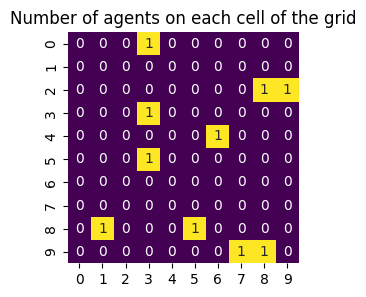

In [199]:
agents_count = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x,y) in model.grid.coord_iter():
    agents_count[x][y] = len(cell_content)

g = sns.heatmap(agents_count, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(3,3)
g.set(title="Number of agents on each cell of the grid")


In [200]:
model = MoneyModel(40, 10, 10)
for i in range(100):
    model.step()

<Axes: >

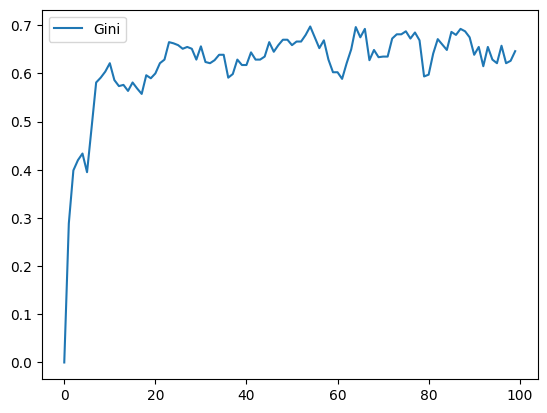

In [201]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()